In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,text
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///../../../../inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by mode

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_mode.csv')).sort_values('observed_boardings', ascending=False)
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df['observed_boardings'].sum(axis=0)
table_df.loc['Total','model_boardings'] = table_df['model_boardings'].sum(axis=0)
table_df.loc['Total','mode'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,mode,observed_boardings,model_boardings,diff,perc_diff
0,0,b,"332,640.45","377,885.88","45,245.43",13.60%
1,4,r,"81,991.16","88,938.03","6,946.87",8.47%
2,2,f,"11,349.85","5,070.85","-6,279.00",-55.32%
3,1,c,"6,354.00","6,222.14",-131.86,-2.08%
4,3,p,"3,235.36","2,807.22",-428.14,-13.23%
5,Total,Total,"435,570.83","480,924.12","45,353.29",10.41%


In [3]:
df_boarding_line = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='description')
df_boarding_line[['observed_boardings','model_boardings']] = df_boarding_line[['observed_boardings','model_boardings']].astype('float')

df_mode = df_boarding_line[df_boarding_line['route_code'].isin([6996,6999,6998])].reset_index()

df_mode['submode'] = df_mode['mode'].map({"r": "Link Red Line", "c": "Sounder"})
df_mode = df_mode[['submode','model_boardings']].copy()
df_mode = df_mode.groupby('submode')['model_boardings'].sum().reset_index()

df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())
df_obs_mode = df_obs.copy()
df_obs_mode['boardings'] = df_obs_mode['boardings'].astype(float)
df_obs_mode = df_obs_mode[df_obs_mode['submode'].isin(["Link","Sounder"])].copy()
df_obs_mode['submode'] = df_obs_mode['submode'].map({"Link": "Link Red Line", "Sounder": "Sounder"})

df_obs_mode = df_obs_mode.groupby(['submode','year'])['boardings'].sum().unstack().reset_index()
df_obs_mode = df_obs_mode.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_mode = df_obs_mode.merge(df_mode, on='submode')

df_mode['2023 % diff'] = (df_mode['model_boardings']-df_mode['2023 boarding'])/df_mode['2023 boarding']
df_mode['2024 % diff'] = (df_mode['model_boardings']-df_mode['2024 boarding'])/df_mode['2024 boarding']
df_mode[['2023 % diff']] = df_mode[['2023 % diff']].applymap(format_percent)
df_mode[['2024 % diff']] = df_mode[['2024 % diff']].applymap(format_percent)

df_mode

,submode,2023 boarding,2024 boarding,model_boardings,2023 % diff,2024 % diff
0,Link Red Line,"78,765.00","91,203.00","85,527.02",8.59%,-6.22%
1,Sounder,"6,765.00","7,711.00","6,222.14",-8.02%,-19.31%


### boarding by agency

In [4]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [5]:
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
table_df.loc['Total','agency'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,agency,observed_boardings,model_boardings,diff,perc_diff
0,2,King County Metro,"253,313.62","282,513.10","29,199.48",11.53%
1,5,Sound Transit,"113,374.00","140,598.79","27,224.79",24.01%
2,0,Community Transit,"25,962.00","28,830.90","2,868.90",11.05%
3,4,Pierce Transit,"21,185.00","14,001.55","-7,183.45",-33.91%
4,6,Washington Ferries,"9,278.21","3,375.98","-5,902.23",-63.61%
5,3,Kitsap Transit,"8,258.00","6,802.52","-1,455.48",-17.63%
6,1,Everett Transit,"4,201.00","4,785.62",584.62,13.92%
7,Total,Total,"435,571.83","480,908.46","45,336.63",10.41%


In [6]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv'), usecols=['agency', 'model_boardings']).sort_values('model_boardings', ascending=False)
df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())

df_obs_agency = df_obs.copy()
df_obs_agency['boardings'] = df_obs_agency['boardings'].astype(float)
df_obs_agency = df_obs_agency.groupby(['agency','year'])['boardings'].sum().unstack().reset_index()
df_obs_agency = df_obs_agency.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_agency = df_obs_agency.merge(df, on='agency')

df_agency['2023 % diff'] = (df_agency['model_boardings']-df_agency['2023 boarding'])/df_agency['2023 boarding']
df_agency['2024 % diff'] = (df_agency['model_boardings']-df_agency['2024 boarding'])/df_agency['2024 boarding']
df_agency[['2023 % diff']] = df_agency[['2023 % diff']].applymap(format_percent)
df_agency[['2024 % diff']] = df_agency[['2024 % diff']].applymap(format_percent)
df_agency = df_agency.replace('inf%', '-')

df_agency

,agency,2023 boarding,2024 boarding,model_boardings,2023 % diff,2024 % diff
0,Community Transit,"23,000.00",0.00,"28,830.90",25.35%,-
1,Everett Transit,0.00,0.00,"4,785.62",-,-
2,King County Metro,"244,306.00","272,556.00","282,513.10",15.64%,3.65%
3,Kitsap Transit,"8,000.00","9,300.00","6,802.52",-14.97%,-26.85%
4,Pierce Transit,"19,974.00",0.00,"14,001.55",-29.90%,-
5,Sound Transit,"115,516.00","133,703.00","140,598.79",21.71%,5.16%
6,Washington Ferries,0.00,0.00,"3,375.98",-,-


In [7]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv')).sort_values('observed_boardings', ascending=False)
df
df = df[df['mode'].isin(['b'])]
df = df.groupby(['agency']).sum()[['observed_boardings','model_boardings']]
df['difference'] = df['model_boardings']-df['observed_boardings']
df['percent diff'] = (df['difference']/df['observed_boardings'])
df[['percent diff']] = df[['percent diff']].applymap(format_percent)
df

# table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
# table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
# table_df.loc['Total','agency'] = 'Total'
# table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
# table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
# table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
# table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
# table_df = table_df.reset_index()
# table_df

,observed_boardings,model_boardings,difference,percent diff
agency,,,,
Community Transit,"25,962.00","28,830.90","2,868.90",11.05%
Everett Transit,"4,201.00","4,785.62",584.62,13.92%
King County Metro,"251,166.45","279,898.19","28,731.73",11.44%
Kitsap Transit,"4,048.00","3,181.92",-866.08,-21.40%
Pierce Transit,"21,185.00","14,001.55","-7,183.45",-33.91%
Sound Transit,"26,079.00","47,172.05","21,093.05",80.88%


### boarding by key route

In [8]:
# df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
# # df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')
# # df = df_boarding_key[df_boarding_key['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
# # df.drop(['route_code','agency'], axis=1, inplace=True)
# # df
# df_boarding_key
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv'))
df = df[df['mode'].isin(['f','p'])][['description','mode','observed_boardings','model_boardings','diff','perc_diff']]
df

,description,mode,observed_boardings,model_boardings,diff,perc_diff
147,973 W Sea Water Taxi,p,759.00,409.28,-349.72,-0.46
148,975 Vashn Water Taxi,f,338.00,472.20,134.20,0.40
270,Seattle-Bremerton FF,f,"1,913.00","1,448.75",-464.25,-0.24
271,Brem-Pt Orchard FF,p,768.00,"1,123.20",355.20,0.46
272,Brem-Annapolis FF,p,469.00,245.83,-223.17,-0.48
273,Seattle-Kingston FF,p,429.00,10.00,-419.00,-0.98
274,Seattle-Southwrth FF,f,631.00,792.82,161.82,0.26
278,WSF Edmonds-Kingston,f,"1,500.13",101.00,"-1,399.13",-0.93
279,WSF Seattle-Bain Isl,f,"5,513.69","2,056.08","-3,457.62",-0.63
280,WSF Seattle-Brem,f,"1,188.97",98.23,"-1,090.73",-0.92


In [9]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff


In [10]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [11]:
# df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
# df['route_code'] = df['route_code'].astype('int')
# df[['route_code','description', '@bvol']]

In [12]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Sounder South,"6,038.00","6,216.94",178.94,2.96%
1,Sounder North,316.00,5.20,-310.80,-98.35%


r^2 : 1.0


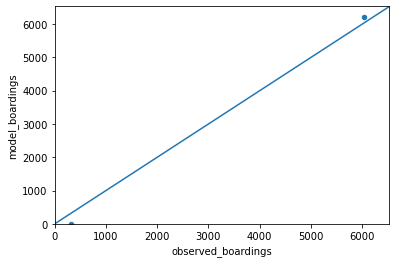

In [13]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [14]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
4,E Line RapidRide,"11,426.00","16,172.34","4,746.34",41.54%
2,C Line RapidRide,"7,250.00","10,394.12","3,144.12",43.37%
3,D Line RapidRide,"9,044.00","8,059.31",-984.69,-10.89%
0,A Line RapidRide,"8,412.00","6,902.39","-1,509.61",-17.95%
1,B Line RapidRide,"4,177.00","3,641.96",-535.04,-12.81%


r^2 : 0.849888750543306


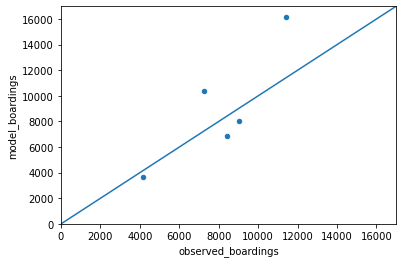

In [15]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### Top routes by agency

In [16]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv'))
# df_top = pd.DataFrame()
# for agency in df['agency'].unique():
#     _df = df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(8)
#     df_top = pd.concat([df_top, _df])
# df = df_top[['agency','description','mode','model_boardings','observed_boardings','diff','perc_diff']]
cols=['agency','description','mode','model_boardings','observed_boardings','diff','perc_diff']

In [17]:
agency = 'King County Metro'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
130,King County Metro,E-Line,b,"16,172.34","11,426.00","4,746.34",0.42
5,King County Metro,7 Rain Bch-ColC-CBD,b,"11,469.48","9,954.00","1,515.48",0.15
128,King County Metro,C Line,b,"10,394.12","7,250.00","3,144.12",0.43
28,King County Metro,40 Ngt-Bal-Fre-CBD,b,"8,927.29","7,208.00","1,719.29",0.24
129,King County Metro,D Line,b,"8,059.31","9,044.00",-984.69,-0.11
132,King County Metro,H-Line,b,"7,211.92","6,907.00",304.92,0.04
126,King County Metro,A Line,b,"6,902.39","8,412.00","-1,509.61",-0.18
67,King County Metro,160 Aub-Kent-Rent,b,"6,679.01","5,058.00","1,621.01",0.32
39,King County Metro,62 SndPt-GLk-Fre-CBD,b,"6,555.17","5,899.00",656.17,0.11
43,King County Metro,70 Udst-Elake-CBD,b,"6,371.27","4,189.00","2,182.27",0.52


In [18]:
agency = 'Sound Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
309,Sound Transit,Light Rail Ang Lk-NG,r,"85,527.02","79,522.00","6,005.02",0.08
293,Sound Transit,550 Bellevue-Seattle,b,"8,572.39","3,351.00","5,221.39",1.56
310,Sound Transit,Commutr Rail Tac-Sea,c,"6,216.94","6,038.00",178.94,0.03
292,Sound Transit,545 Redmond-Seattle,b,"5,798.55","3,340.00","2,458.55",0.74
286,Sound Transit,512 Everett-Northgte,b,"5,401.87","2,251.00","3,150.87",1.40
288,Sound Transit,522 Woodinvl-Roosvlt,b,"5,314.49","1,736.00","3,578.49",2.06
294,Sound Transit,554 Issaquah-Seattle,b,"4,906.94","2,153.00","2,753.94",1.28
300,Sound Transit,578 Seattle-Puyallup,b,"3,150.92","1,460.00","1,690.92",1.16
296,Sound Transit,560 W Sea-Bellevue,b,"2,222.91","1,227.00",995.91,0.81
298,Sound Transit,574 Lakewood-SeaTac,b,"2,184.62","1,848.00",336.62,0.18


In [19]:
agency = 'Community Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
230,Community Transit,Swift Blue,b,"6,366.07","3,804.00","2,562.07",0.67
231,Community Transit,Swift Green,b,"2,765.45","3,000.00",-234.55,-0.08
200,Community Transit,116 Edm-Silver Firs,b,"2,175.91",955.00,"1,220.91",1.28
199,Community Transit,115 McClm P&R-AurVil,b,"1,729.53","1,133.00",596.53,0.53
205,Community Transit,201 Smokey Pt-Lynnwd,b,"1,526.95","1,049.00",477.95,0.46
206,Community Transit,202 Smokey Pt-Lynnwd,b,"1,526.34","1,002.00",524.34,0.52
191,Community Transit,101 Mar P&R-Aur Vill,b,"1,389.11",945.00,444.11,0.47
203,Community Transit,130 Edmonds-Lynnwood,b,919.55,618.00,301.55,0.49
198,Community Transit,113 Mukilteo-Lynn TC,b,871.71,802.00,69.71,0.09
216,Community Transit,280 Gran Falls-Evrt,b,747.81,335.00,412.81,1.23


In [20]:
agency = 'Pierce Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
160,Pierce Transit,1 6th Ave-Pac Ave,b,"1,595.65","3,035.00","-1,439.35",-0.47
185,Pierce Transit,402 Meridian,b,"1,088.32",626.00,462.32,0.74
184,Pierce Transit,400 Puyllp-Tacoma,b,999.61,336.00,663.61,1.98
161,Pierce Transit,2 S 19th-Bridgeport,b,990.08,"1,729.00",-738.92,-0.43
189,Pierce Transit,500 Federal Way,b,914.91,845.00,69.91,0.08
162,Pierce Transit,3 Lakewood-Tacoma,b,858.32,"1,250.00",-391.68,-0.31
190,Pierce Transit,501 Miltn-Fed Way,b,849.00,431.00,418.00,0.97
169,Pierce Transit,41 S 56th St-Salish,b,781.21,"1,088.00",-306.79,-0.28
163,Pierce Transit,4 Lakewd-South Hill,b,662.68,968.00,-305.32,-0.32
172,Pierce Transit,48 Sheridan-M St,b,475.67,"1,065.00",-589.33,-0.55


In [21]:
agency = 'Kitsap Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
270,Kitsap Transit,Seattle-Bremerton FF,f,"1,448.75","1,913.00",-464.25,-0.24
271,Kitsap Transit,Brem-Pt Orchard FF,p,"1,123.20",768.00,355.20,0.46
274,Kitsap Transit,Seattle-Southwrth FF,f,792.82,631.00,161.82,0.26
244,Kitsap Transit,217 Brem-Silverdle E,b,602.46,417.00,185.46,0.44
242,Kitsap Transit,212 Brem-Silverdle W,b,338.11,679.00,-340.89,-0.50
272,Kitsap Transit,Brem-Annapolis FF,p,245.83,469.00,-223.17,-0.48
260,Kitsap Transit,390 Poulsbo-Bainbrdg,b,237.47,170.00,67.47,0.40
240,Kitsap Transit,8 Bethel,b,195.73,152.00,43.73,0.29
243,Kitsap Transit,215 McWilliams,b,185.73,115.00,70.73,0.62
259,Kitsap Transit,86 Southwrth Shuttle,b,177.91,91.00,86.91,0.96


In [22]:
agency = 'Everett Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
316,Everett Transit,7 Coll Stn-Mall Stn,b,"2,625.37","2,239.00",386.37,0.17
320,Everett Transit,29 Coll Stn-Mall Stn,b,"1,277.85",881.00,396.85,0.45
313,Everett Transit,3 Seaway TC-Evt Stn,b,345.37,285.00,60.37,0.21
317,Everett Transit,8 Airport Rd-Evt Stn,b,129.01,156.00,-26.99,-0.17
312,Everett Transit,2 Marnr P&R-Mall Stn,b,99.39,148.00,-48.61,-0.33
315,Everett Transit,6 Waterfront-Evt Stn,b,91.06,62.00,29.06,0.47
314,Everett Transit,4 Evt Stn-Collge Stn,b,75.83,114.00,-38.17,-0.33
318,Everett Transit,12 Mall Stn-Seawy TC,b,72.02,256.00,-183.98,-0.72
319,Everett Transit,18 Mukilteo-Evt Stn,b,69.72,60.00,9.72,0.16


### boarding on lines by agency

r^2 Community Transit: 0.9103247230739021
r^2 Everett Transit: 0.9908522391563216
r^2 King County Metro: 0.9449884750988107
r^2 Kitsap Transit: 0.8983284154827704
r^2 Pierce Transit: 0.7261734588888624
r^2 Sound Transit: 0.9964371478722448
r^2 Washington Ferries: 0.905510639453263


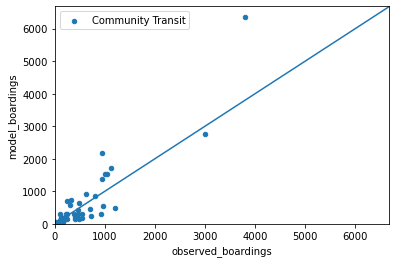

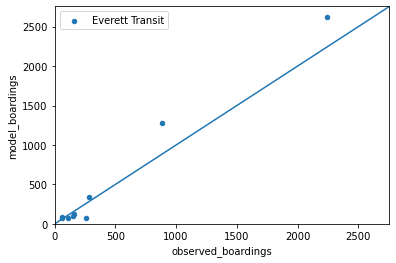

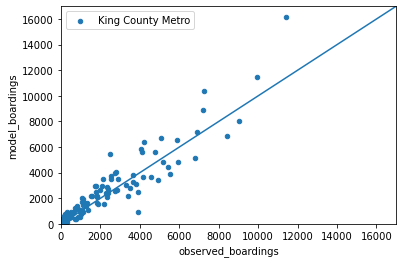

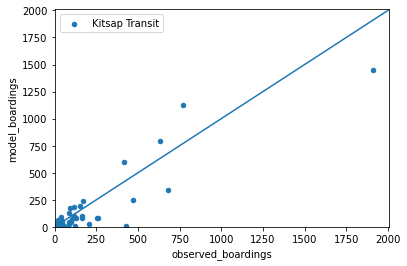

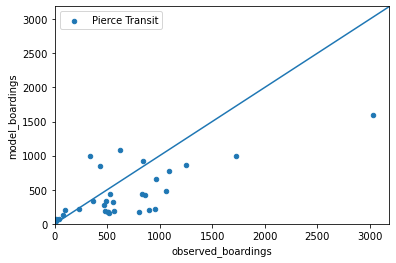

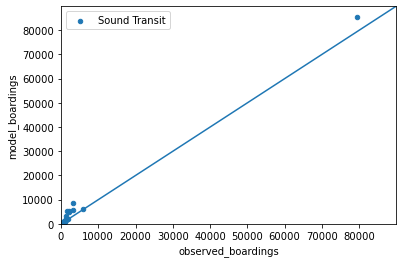

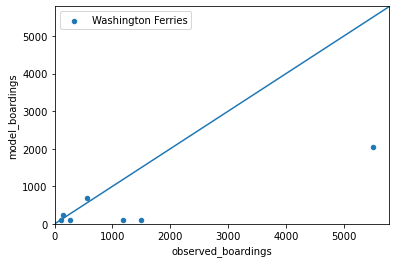

In [23]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [24]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Husky Stadium,"4,821.00","3,781.20","-1,039.80",-21.57%
Westlake,"9,739.00","11,187.36","1,448.36",14.87%
Symphony,"4,263.00","6,855.56","2,592.56",60.82%
Pioneer Square,"2,664.00","5,627.23","2,963.23",111.23%
Int'l District,"4,797.00","1,915.44","-2,881.56",-60.07%
Capitol Hill,"7,263.00","7,855.56",592.56,8.16%
Stadium,"2,320.00",309.80,"-2,010.20",-86.65%
SODO,"1,652.00","2,370.15",718.15,43.47%
Beacon Hill,"2,211.00","1,433.38",-777.62,-35.17%


In [25]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/Symphony'
df_combined.loc[['Symphony'],'station_group'] = 'Westlake/Symphony'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined.loc[['Husky Stadium','Capitol Hill','Westlake/Symphony',"Pioneer Square/Int'l District",
                 'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                 "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Husky Stadium,"4,821.00","3,781.20","-1,039.80",-21.57%
Capitol Hill,"7,263.00","7,855.56",592.56,8.16%
Westlake/Symphony,"14,002.00","18,042.92","4,040.92",28.86%
Pioneer Square/Int'l District,"7,461.00","7,542.67",81.67,1.09%
Stadium/SODO,"3,972.00","2,679.95","-1,292.05",-32.53%
Beacon Hill/Mount Baker,"4,269.00","3,294.33",-974.67,-22.83%
Columbia City,"1,840.00","1,841.39",1.39,0.08%
Othello/Rainier Beach,"3,486.00","3,932.86",446.86,12.82%
Tukwila Int'l Blvd,"2,423.00","2,821.37",398.37,16.44%


In [26]:
os.getcwd()

'C:\\Workspace\\sc_2023_01_30_25\\scripts\\summarize\\validation_network\\validation_scripts'

In [27]:
df_obs = pd.read_sql(
    "SELECT * FROM light_rail_station_boardings WHERE year IN (2023, 2024)",
    con=conn,
)
df_obs.rename(columns={"boardings": "observed_boardings"}, inplace=True)

# df_obs.groupby(['year','station_name']).sum()
df_obs = pd.pivot_table(df_obs, values='observed_boardings', columns='year', index='station_name', aggfunc=np.sum)
df_obs = df_obs.fillna(0)
df_obs

df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name', usecols=['station_name','model_boardings'])
df = df.merge(df_obs,  left_index=True, right_index=True, how='outer')
df = df[df.index != 'Total']
df = df[~df['model_boardings'].isnull()]
df

,model_boardings,2023,2024
station_name,,,
Angle Lake,"2,917.62","3,840.00","5,093.00"
Beacon Hill,"1,433.38","2,211.00","2,672.00"
Capitol Hill,"7,855.56","7,263.00","8,207.00"
Columbia City,"1,841.39","1,840.00","2,145.00"
Husky Stadium,"3,781.20","4,821.00","5,122.00"
Int'l District,"1,915.44","4,797.00","5,372.00"
Mount Baker,"1,860.95","2,058.00","2,458.00"
Northgate Station,"8,835.63","10,430.00","4,150.00"
Othello,"2,209.41","2,083.00","2,466.00"


## light rail stop transfers

In [28]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Husky Stadium,0.81,-99.00,99.81,-100.82%
Westlake,0.12,0.36,-0.25,-68.27%
Symphony,0.27,0.20,0.07,32.91%
Pioneer Square,0.38,0.16,0.22,137.65%
Int'l District,0.52,0.45,0.07,16.08%
Capitol Hill,0.06,-99.00,99.06,-100.06%
Stadium,0.37,0.12,0.25,211.04%
SODO,0.63,0.31,0.32,101.00%
Beacon Hill,0.32,0.35,-0.04,-10.71%
